### Library imports

In [1]:
# Install necessary packages
import sys
!{sys.executable} -m pip install imbalanced-learn shap statsmodels xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import time
import random
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC, ADASYN
from imblearn.under_sampling import TomekLinks
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mutual_info_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.feature_selection import RFECV

import statsmodels.api as sm
from xgboost import XGBClassifier

### Data import

In [3]:
loans = pd.read_csv('./accepted_2007_to_2018Q4.csv')

/scratch/tmp.22582023.bandonov/ipykernel_1482466/2434044024.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  loans = pd.read_csv('./accepted_2007_to_2018Q4.csv')


#### Removal of unavailable and unusable features

In [4]:
# These are features that are unavailable at inference time, and cannot be used.
unavailable_features = [
    'collection_recovery_fee',
    'funded_amnt',
    'funded_amnt_inv',
    'initial_list_status',
    'issue_d',
    'last_credit_pull_d',
    'last_fico_range_high',
    'last_fico_range_low',
    'last_pymnt_amnt',
    'last_pymnt_d',
    'next_pymnt_d',
    'out_prncp',
    'out_prncp_inv',
    'pymnt_plan', 
    'recoveries',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp',
    'hardship_flag',
    'hardship_type',
    'hardship_reason',
    'hardship_status',
    'deferral_term',
    'hardship_amount',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'hardship_length',
    'hardship_dpd',
    'hardship_loan_status',
    'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',
    'disbursement_method',
    'policy_code'
]

print(f'Unavailable features: {len(unavailable_features)} / {len(loans.columns)}')
loans['loan_status'].value_counts()

Unavailable features: 44 / 151


loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [5]:
# These are features which are available at runtime, but should not be used for inference, either because they introduce bias,
# or because they first have to be converted into a meaningful representation before being able to be used (e.g. loan description)
unused_features = [
    'addr_state',
    'desc',
    'grade',
    'emp_title',
    'id',
    'member_id',
    'sub_grade',
    'title',
    'url',
    'zip_code',
]

# TODO: experiment with addr_state and zip_code, leave out (sub_)grade.
print(f'Unused features: {len(unused_features)} / {len(loans.columns)}')

Unused features: 10 / 151


In [6]:
# Drop these two sets of features
features_to_drop = unavailable_features + unused_features
loans = loans.drop(columns=features_to_drop)
print(f'Remaining features: {len(loans.columns)}')

Remaining features: 97


In [7]:
# Extract only the loan defaults and the fully paid loans
defaulted_loans_labels = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']
default_loans = loans[loans['loan_status'].isin(defaulted_loans_labels)]
paid_loans = loans[loans['loan_status'] == 'Fully Paid']

# Join the loan defaults and paid loans. This is now our dataset.
loans = pd.concat([paid_loans, default_loans])

#### Introducing bias (probably should not include this for students)

In [8]:
base_race_prob_dict = { #based loosely off of https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States
    'white': .5,
    'latino': .2, 
    'black': .2, 
    'asian': .03, 
    'american_indian': .02
}	
base_race_prob_dict['other'] = 1. - sum(base_race_prob_dict.values())

prob_college_given_race = {
    # based on https://en.wikipedia.org/wiki/Educational_attainment_in_the_United_States#/media/File:Educational_Attainment_Statistics.webp
    'white': .45,
    'latino': .25, 
    'black': .28, 
    'asian': .71, 
    'american_indian': .11, 
    'other':  .3
}
prob_education_given_race = defaultdict(dict)
for r in prob_college_given_race.keys():
    prob_education_given_race[r]['College degree'] = prob_college_given_race[r]
    remainder = 1. - prob_education_given_race[r]['College degree']
    # split probability between other two options bc don't really know the spread
    prob_education_given_race[r]['GED/High school'], prob_education_given_race[r]['None'] = remainder/2., remainder/2.

prob_loan_default = len(default_loans)/len(loans)

prob_default_given_race = {}
for r in base_race_prob_dict.keys():
    prob_default_given_race[r] = prob_loan_default*np.random.uniform(0.5, 1.5)
renorm_constant = sum([prob_default_given_race[r]*base_race_prob_dict[r] for r in base_race_prob_dict.keys()])/prob_loan_default
prob_default_given_race = {k:v/renorm_constant for k,v in prob_default_given_race.items()}

prob_race_given_default = {}
for r in base_race_prob_dict.keys():
    prob_race_given_default[r] = prob_default_given_race[r]*base_race_prob_dict[r]/prob_loan_default

np.random.seed(42)
added_cols = [c for c in loans.columns if 'race' in c or 'education' in c]
loans.drop(added_cols, axis=1, inplace=True)

vals, probs_default = list(zip(*prob_race_given_default.items()))
probs_no_default = [base_race_prob_dict[v] for v in vals]
def sample_race(row):
    probs = probs_no_default if row['loan_status'] == 'Fully Paid' else probs_default
    sample = np.random.multinomial(1, probs)
    return vals[list(sample).index(1)]
loans['race'] = loans.apply(sample_race, axis=1)

def sample_education(row):
    vals, probs = list(zip(*prob_education_given_race[row['race']].items()))
    sample = np.random.multinomial(1, probs)
    return vals[list(sample).index(1)]
loans['education'] = loans.apply(sample_education, axis=1)

#### Metrics for bias evaluation

In [9]:
def compute_pseudo_r2(df, dependent_var, independent_var):
    """
    Computes the pseudo-R^2 (McFadden's R^2) for logistic regression 
    between two categorical variables.

    Parameters:
    - df: pandas DataFrame containing the data
    - dependent_var: str, name of the dependent (target) variable
    - independent_var: str, name of the independent (predictor) variable

    Returns:
    - float, the McFadden's pseudo-R^2 value
    """
    # Encode categorical variables as numeric
    le_target = LabelEncoder()
    le_predictor = LabelEncoder()
    y = le_target.fit_transform(df[dependent_var])
    X = le_predictor.fit_transform(df[independent_var])
    
    # Add a constant to the independent variable for the intercept
    X = sm.add_constant(X)
    
    # Fit the logistic regression model
    if len(set(y)) == 2:
        # Binary logistic regression
        model = sm.Logit(y, X)
    else:
        # Multinomial logistic regression
        model = sm.MNLogit(y, X)
    result = model.fit(disp=0)  # Suppress output
    
    # Compute McFadden's pseudo-R^2
    llf = result.llf  # Log-likelihood of the fitted model
    llnull = result.llnull  # Log-likelihood of the null model
    pseudo_r2 = 1 - (llf / llnull)
    
    return pseudo_r2

def compute_bias_metrics(df, att1, att2):
    print("Mutual information:", mutual_info_score(df[att1], df[att2]))
    print("Pseudo R2:", compute_pseudo_r2(df, att1, att2))

In [11]:
compute_bias_metrics(loans, 'loan_status', 'race')

Mutual information: 0.012034458405675613
Pseudo R2: 0.012170069547648987


In [12]:
categorical_education = pd.get_dummies(loans[['education']], dtype='float64')
categorical_race = pd.get_dummies(loans[['race']], dtype='float64')
loans = pd.concat([loans, categorical_race, categorical_education], axis=1).drop(['race', 'education'], axis=1)

### Data Analysis

In [13]:
# See how loan labels are distributed ('loan_status' is the variable we would like to predict in this task)
status_counts = Counter(loans['loan_status'])
n_loan_defaults = sum([status_counts[label] for label in defaulted_loans_labels])
n_paid_loans = status_counts['Fully Paid']
print(f"Loan defaults: {n_loan_defaults}")
print(f"Fu paid loans: {n_paid_loans}")
print("There is data imbalance!")

Loan defaults: 269360
Fu paid loans: 1076751
There is data imbalance!


In [14]:
individual_loans = loans[loans['application_type'] == 'Individual']
print("Individual loans:", len(individual_loans), ",", round(len(individual_loans) / len(loans), 2))
print("Joint loans:", len(loans) - len(individual_loans), ",", round((len(loans) - len(individual_loans)) / len(loans), 2))

Individual loans: 1320305 , 0.98
Joint loans: 25806 , 0.02


In [15]:
float_cols = loans.select_dtypes(include='float64')
object_cols = loans.select_dtypes(include='object')

print(f'Numerical features: {len(float_cols.columns)}')
print(f'Categorical features: {len(object_cols.columns)}')

possible_values = {}
for col in object_cols.columns:
    possible_values[col] = list(pd.unique(object_cols[col]))

n_na = 0
for key, val in possible_values.items():
    has_na_vals = any(pd.isna(val))
    print(f'{key} -> {val[:10]}, {len(val)}, {has_na_vals}')
    if has_na_vals:
        n_na += 1

print("Number of features with NA:", n_na) 

Numerical features: 96
Categorical features: 10
term -> [' 36 months', ' 60 months'], 2, False
emp_length -> ['10+ years', '3 years', '4 years', '6 years', '8 years', '2 years', '9 years', '< 1 year', '1 year', '5 years'], 12, True
home_ownership -> ['MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE', 'OTHER'], 6, False
verification_status -> ['Not Verified', 'Source Verified', 'Verified'], 3, False
loan_status -> ['Fully Paid', 'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'], 4, False
purpose -> ['debt_consolidation', 'small_business', 'home_improvement', 'major_purchase', 'credit_card', 'other', 'house', 'vacation', 'medical', 'car'], 14, False
earliest_cr_line -> ['Aug-2003', 'Dec-1999', 'Aug-2000', 'Jun-1998', 'Oct-1987', 'Jun-1990', 'Feb-1999', 'Apr-2002', 'Nov-1994', 'Jun-1996'], 740, True
application_type -> ['Individual', 'Joint App'], 2, False
verification_status_joint -> [nan, 'Not Verified', 'Verified', 'Source Verified'], 4, True
sec_app_earliest_cr_l

Let's investigate the distribution of annual_income in our dataset.

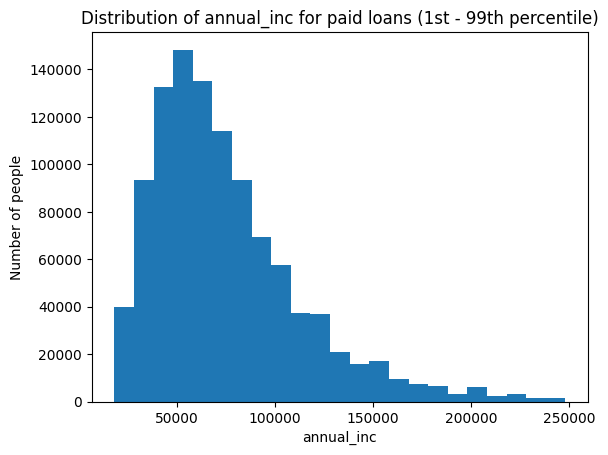

Description
count    1.076751e+06
mean     7.770595e+04
std      7.093496e+04
min      0.000000e+00
25%      4.700000e+04
50%      6.500000e+04
75%      9.300000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64


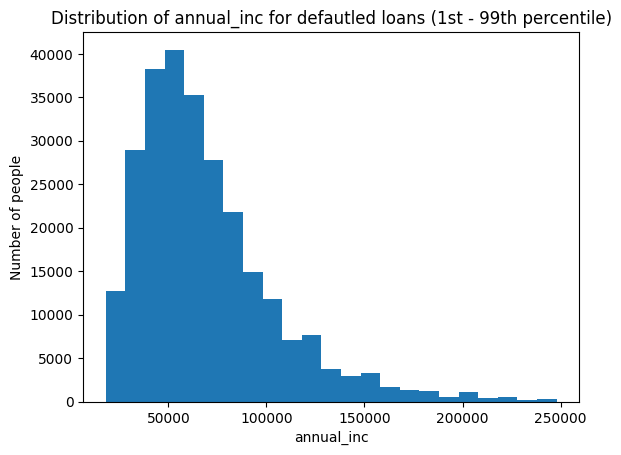

Description
count    2.693600e+05
mean     7.039883e+04
std      6.538521e+04
min      0.000000e+00
25%      4.300000e+04
50%      6.000000e+04
75%      8.500000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64


In [16]:
def plot_distribution(df, attribute, typ, spacing):
    per_1 = int(np.percentile(loans[attribute], 1))
    per_99 = int(np.percentile(loans[attribute], 99))
    bins = range(per_1, per_99, spacing)
    plt.hist(df[attribute], bins=bins)
    plt.title(f'Distribution of {attribute} for {typ} loans (1st - 99th percentile)')
    plt.xlabel(attribute)
    plt.ylabel('Number of people')
    plt.show()

    print("Description")
    print(df[attribute].describe())

plot_distribution(paid_loans, 'annual_inc', 'paid', 10_000)
plot_distribution(default_loans, 'annual_inc', 'defautled', 10_000)

We notice that the annual income of people with loan defaults is slightly lower than the ones with fully paid loans (~ $5000 median difference)

We now plot the requested loan amount per paid loan or loan default 

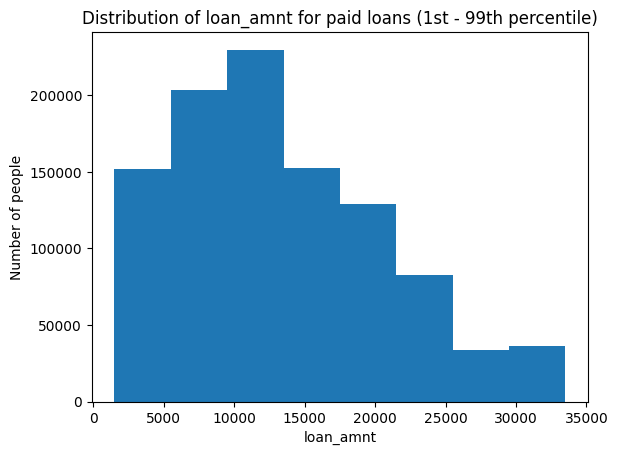

Description
count    1.076751e+06
mean     1.413437e+04
std      8.669029e+03
min      5.000000e+02
25%      7.500000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64


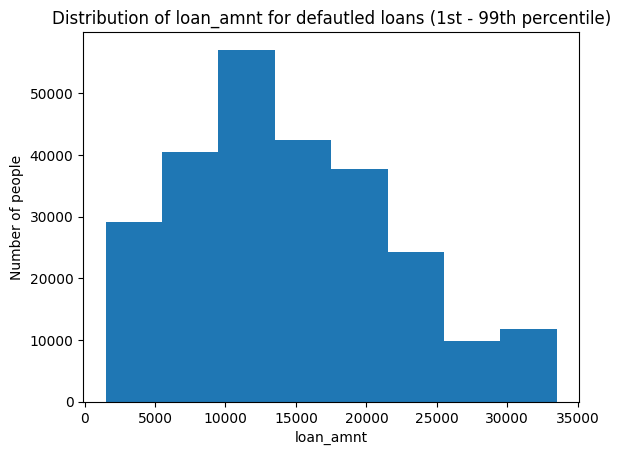

Description
count    269360.000000
mean      15547.816955
std        8814.732243
min         500.000000
25%        9000.000000
50%       14300.000000
75%       20400.000000
max       40000.000000
Name: loan_amnt, dtype: float64


In [17]:
plot_distribution(paid_loans, 'loan_amnt', 'paid', 4000)
plot_distribution(default_loans, 'loan_amnt', 'defautled', 4000)

We can see that people who default their loans request a slightly higher amount (~ $2300 median difference)

Now, let us plot the correlation between the monthly salary and installment amount.

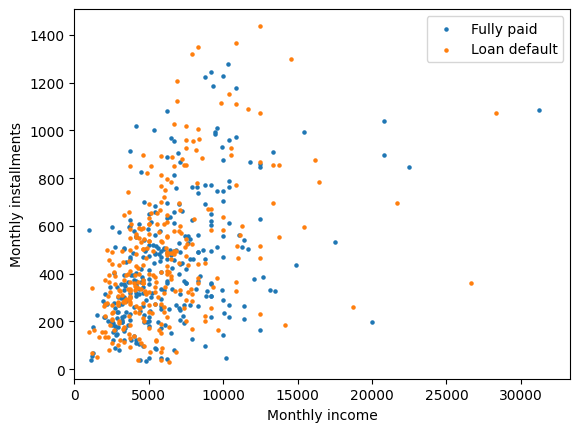

In [18]:
n_samples_each = 300

paid_loans_sample = paid_loans.sample(n=n_samples_each, random_state=42)
plt.scatter(
    paid_loans_sample['annual_inc'] / 12, # Monthly income
    paid_loans_sample['installment'],
    label='Fully paid',
    s=5
)


default_loans_sample = default_loans.sample(n=n_samples_each, random_state=42)
plt.scatter(
    default_loans_sample['annual_inc'] / 12,
    default_loans_sample['installment'],
    label='Loan default',
    s=5
)

plt.xlabel('Monthly income')
plt.ylabel('Monthly installments') 
plt.xlim(0, 400_000 / 12)
plt.legend()
plt.show()

There seems to be positive correlation between the monthly income and the installment amount, which does make sense. However, from the plot above, it seems difficult to determine whether a loan will default or not based on these two features alone.

Now, let's see how the high and low **FICO range** affect the outcome of a loan (those are indicators for the trustworthiness of the borrower).

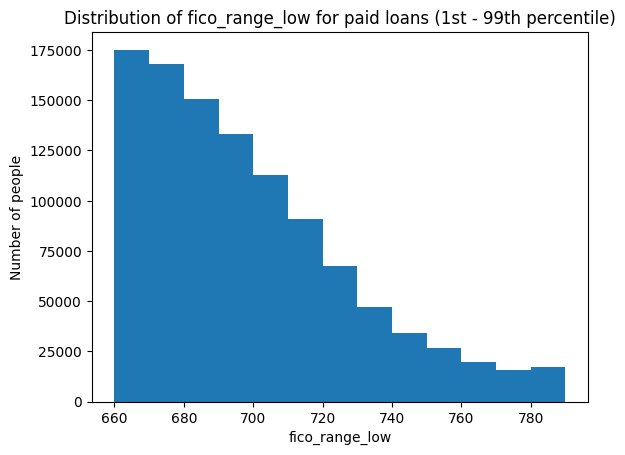

Description
count    1.076751e+06
mean     6.982639e+02
std      3.283365e+01
min      6.250000e+02
25%      6.750000e+02
50%      6.900000e+02
75%      7.150000e+02
max      8.450000e+02
Name: fico_range_low, dtype: float64


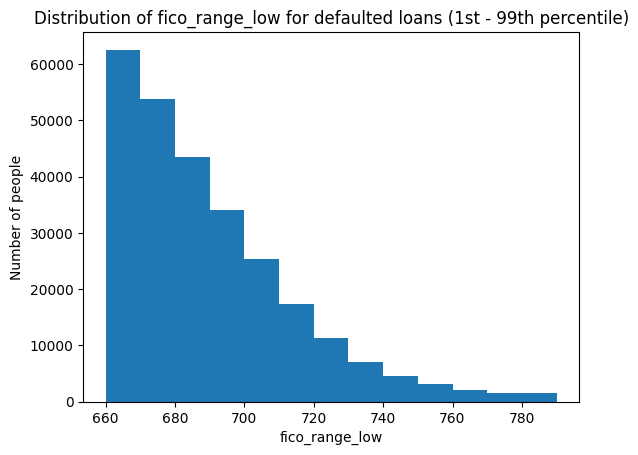

Description
count    269360.000000
mean        687.831360
std          25.955851
min         615.000000
25%         670.000000
50%         680.000000
75%         700.000000
max         845.000000
Name: fico_range_low, dtype: float64


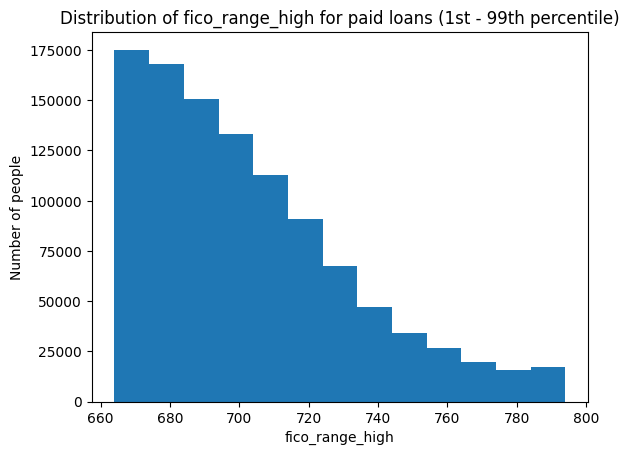

Description
count    1.076751e+06
mean     7.022641e+02
std      3.283437e+01
min      6.290000e+02
25%      6.790000e+02
50%      6.940000e+02
75%      7.190000e+02
max      8.500000e+02
Name: fico_range_high, dtype: float64


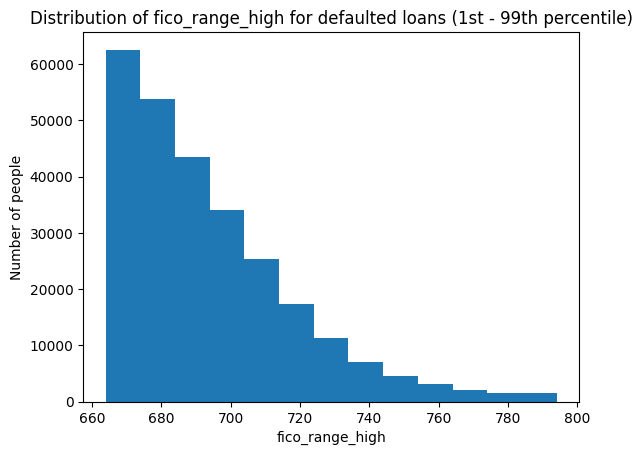

Description
count    269360.000000
mean        691.831411
std          25.956166
min         619.000000
25%         674.000000
50%         684.000000
75%         704.000000
max         850.000000
Name: fico_range_high, dtype: float64


In [19]:
plot_distribution(paid_loans, 'fico_range_low', 'paid', 10)
plot_distribution(default_loans, 'fico_range_low', 'defaulted', 10)
plot_distribution(paid_loans, 'fico_range_high', 'paid', 10)
plot_distribution(default_loans, 'fico_range_high', 'defaulted', 10)

The FICO range does not seem to be a good indicator for whether the loan will default. There's only a ~10 median difference in scores between paid and defaulted loans.

Lastly, we will plot the home_ownership variable to see whether that is different between paid loans and defautled loans.

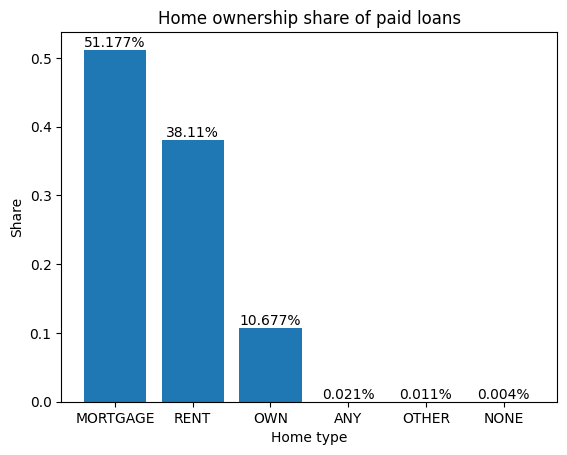

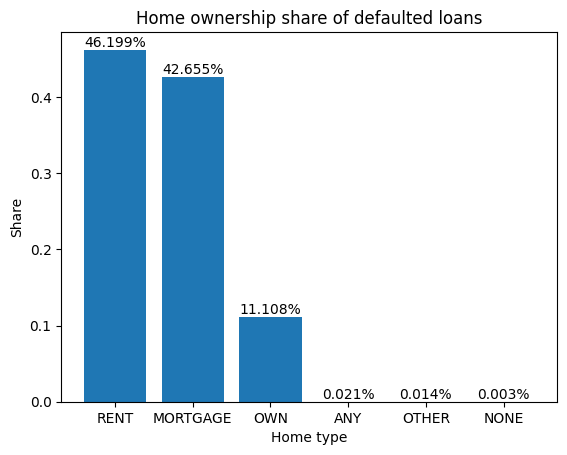

In [20]:
def plot_home_ownership(df, typ):
    home_ownership = df.groupby('home_ownership').count().to_dict()['loan_status']
    n_entries = sum(home_ownership.values())
    home_ownership =  [(val / n_entries, key) for key, val in home_ownership.items()]
    home_ownership.sort(reverse=True)

    x, y =  [x[1] for x in home_ownership], [x[0] for x in home_ownership]
    bars = plt.bar(x, y)
    
    for bar in bars:
        yval = f"{round(bar.get_height() * 100, 3)}%"
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{yval}', ha='center', va='bottom')

    plt.title(f'Home ownership share of {typ} loans')
    plt.ylabel('Share')
    plt.xlabel('Home type')
    plt.show()

plot_home_ownership(paid_loans, 'paid')
plot_home_ownership(default_loans, 'defaulted')

We notice that rent and mortgage swapped places between the paid and defaulted loans. There is a +8% and a -9% change between defaulted loans and paid loans for renting a home and having a mortgage on a home, respectively - these are quite significant numbers, so this feature might be important.

### Data cleaning

Data is cleaned when calling the train_eval_model function (found near the end of the notebook). This follows several steps:

1. All text features are converted into numerical ones
2. Features are imputed
3. Features are scaled
4. Classes are balanced

For all steps but 1. an approach from several implemented ones can be selected.

#### Feature imputation

##### Approach 1: Simple imputation. Fast, but not as accurate

In [21]:
def simple_imputation(X_train, X_test):
    simple_imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(simple_imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(simple_imputer.transform(X_test), columns=X_test.columns)
    
    return X_train, X_test

In [22]:
def better_imputation(df, cat_marker="Missing", num_impute_strategy="median", return_imputer=False):
    """
    Impute missing values in a dataframe:
    - Categorical variables: Filled with a marker (default: 'Missing')
    - Numerical variables: Imputed with the specified strategy (median or mean)
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    cat_marker (str, optional): Marker for missing categorical values (default: "Missing")
    num_impute_strategy (str, optional): Strategy for imputing numerical columns ('median' or 'mean', default: 'median')
    return_imputer (bool, optional): If True, returns a function that can apply the same imputation to another dataframe.
    
    Returns:
    pd.DataFrame: Dataframe with imputed values
    function (optional): A function that can be used to apply the same imputation to another dataframe
    """
    df = df.copy()  # Avoid modifying the original dataframe
    
    # Identify categorical and numerical columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    num_cols = df.select_dtypes(include=["number"]).columns
    
    # Determine numerical imputation values
    if num_impute_strategy == "mean":
        num_impute_values = df[num_cols].mean()
    else:
        num_impute_values = df[num_cols].median()
    
    # Impute categorical columns
    df[cat_cols] = df[cat_cols].fillna(cat_marker)
    
    # Impute numerical columns
    for col in num_cols:
        df[col] = df[col].fillna(num_impute_values[col])
    
    if return_imputer:
        def imputer(new_df):
            new_df = new_df.copy()
            new_df[cat_cols] = new_df[cat_cols].fillna(cat_marker)
            for col in num_cols:
                new_df[col] = new_df[col].fillna(num_impute_values[col])
            return new_df
        return df, imputer
    
    return df

##### (WIP) Approach 2: More involved imputation by manually selecting how each feature should be imputed.

In [23]:
def involved_imputation(df):
    features = loans.columns
    na_features = [feature for feature in features if any(pd.isna(loans[feature]))]
    print(len(na_features), '/', len(features), na_features)
    for feature in na_features[:10]:
        to_plot = loans[feature].copy()
        plt.hist(to_plot)
        # plt.yscale('log')
        plt.title(feature)
        plt.show()

##### Choose an imputation approach

In [24]:
def impute(X, **kwargs):
    print('Imputing features...')
    return better_imputation(X, **kwargs)

#### Convert text features into numerical ones

In [25]:
non_na_categorical_features = [
    'term',
    'home_ownership',
    'verification_status',
    'purpose',
    'application_type'
]

na_categorical_features = ['verification_status_joint']

def get_employment_years(years_string):
        if type(years_string) is not str:
            return years_string
    
        if '<' in years_string:
            return 0
        
        if '10' in years_string:
            return 10
        
        return int(years_string[0])

def convert_text_features_to_numerical(loans_orig: pd.DataFrame, in_place=False):
    loans = loans_orig if in_place else loans_orig.copy()

    # Impute categorical features by using dummy variables
    dummies_for_non_na_categorical_features = pd.get_dummies(loans[non_na_categorical_features], dtype='float64', drop_first=True)
    dummies_for_na_categorical_features = pd.get_dummies(loans[na_categorical_features], dtype='float64', drop_first=True, dummy_na=True)
    
    loans = pd.concat([
        loans.drop(non_na_categorical_features + na_categorical_features, axis=1),
        dummies_for_non_na_categorical_features,
        dummies_for_na_categorical_features
    ], axis=1)
    
    # Convert dates of the format Mon-Year to just an integer representing the year
    map_datestr_to_year = lambda x: int(x[-4:]) if type(x) is str else x
    loans['earliest_cr_line'] = loans['earliest_cr_line'].map(map_datestr_to_year)
    loans['sec_app_earliest_cr_line'] = loans['sec_app_earliest_cr_line'].map(map_datestr_to_year)

    # Convert the emp_length string to a number representing the number of employment years.
    loans['emp_length'] =  loans['emp_length'].map(get_employment_years)

    return loans

#### Feature scaling

In [26]:
def scale_robustly(X_unscaled, return_scaler=False):
    """
    Scales numerical features using RobustScaler to handle outliers.
    
    Parameters:
    X_unscaled (pd.DataFrame): Dataframe containing numerical features to be scaled.
    return_scaler_function (bool, optional): If True, returns a function that can apply the same transformation to new data.
    
    Returns:
    pd.DataFrame: Scaled dataframe.
    function (optional): A function that can be used to apply the same scaling to another dataframe.
    """
    robust_scaler = RobustScaler()
    X_scaled = pd.DataFrame(robust_scaler.fit_transform(X_unscaled), 
                            columns=X_unscaled.columns, 
                            index=X_unscaled.index)
    
    if return_scaler:
        def scaler_function(new_X):
            return pd.DataFrame(robust_scaler.transform(new_X), 
                                columns=new_X.columns,
                               index=new_X.index)
        return X_scaled, scaler_function
    
    return X_scaled

##### Choose a scaling approach

In [27]:
def scale(X_train, **kwargs):
    print('Scaling features...')
    return scale_robustly(X_train, **kwargs)

#### Deal with class imbalance 

In [28]:
# Some variables used in all of the following approaches
def imbalanced_classes_parameters(y_imbalanced):
    class_sizes = [len(y_imbalanced[y_imbalanced == i])for i in range(2)]
    size_difference = abs(class_sizes[0] - class_sizes[1])
    minority_class = np.argmin(class_sizes)
    majority_class = 1 - minority_class

    return class_sizes, size_difference, minority_class, majority_class

##### Approach 1: Oversampling the minority class

In [29]:
# 1.1 Duplicate examples from the minority class, until sizes of both classes match
def duplicate_minority_class(X_imbalanced, y_imbalanced):
    class_sizes, size_difference, minority_class, majority_class = imbalanced_classes_parameters(y_imbalanced)
    
    index_to_resample = y_imbalanced == minority_class
    upsampled_minority_class = X_imbalanced[index_to_resample].sample(n=size_difference,  replace=True)
    upsampled_minority_labels = y_imbalanced[upsampled_minority_class.index]
    X = pd.concat([X_imbalanced, upsampled_minority_class])
    y = pd.concat([y_imbalanced, upsampled_minority_labels])
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    reshuffled_index = np.random.permutation(X.index)
    X = X.reindex(reshuffled_index)
    y = y.reindex(reshuffled_index)
    return X, y

In [30]:
# 1.2 SMOTE (Create synthetic samples by interpolating between existing minority samples)
# https://arxiv.org/pdf/1106.1813
# Note: This might take several minutes.
def get_categorical_features(X):
    base_categorical_features = non_na_categorical_features + na_categorical_features + ['race']
    categorical_features = [
        column for column in X.columns
        if any(
            column.startswith(base_categorical_feature) 
            for base_categorical_feature in base_categorical_features
        )
    ]

    return categorical_features

def generate_synthetic_datapoints(row_index, neighbor_indices, samples, n_samples, categorical_features):
    s = time.time()
    row = samples.iloc[row_index]
    neighbor_indices = np.random.choice(neighbor_indices, n_samples)
    neighbors = samples.iloc[neighbor_indices]

    generated_samples = []
    for index, neighbor in neighbors.iterrows():
        alpha = random.random()
        new_sample = (1 - alpha) * row + alpha * neighbor

        categorical_choices = np.array([row[categorical_features], neighbor[categorical_features]])
        categorical_indices = np.random.randint(0, 2, size=len(categorical_features))
        new_sample[categorical_features] = categorical_choices[categorical_indices, np.arange(len(categorical_features))]
        generated_samples.append(new_sample)
        
    e = time.time()
    return generated_samples

def smote(X_imbalanced, y_imbalanced, k=5):
    class_sizes, size_difference, minority_class, majority_class = imbalanced_classes_parameters(y_imbalanced)
    categorical_features = get_categorical_features(X_imbalanced)
    index_to_resample = y_imbalanced == minority_class
    minority_samples = X_imbalanced[index_to_resample]
    
    smote_n = int(np.round(size_difference / class_sizes[minority_class]))
    synthetic_samples = []

    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    nearest_neighbors.fit(minority_samples)

    neighbor_indices_per_row = nearest_neighbors.kneighbors(minority_samples, n_neighbors=k+1, return_distance=False)
    for neighbor_indices in neighbor_indices_per_row:
        generated_datapoints = generate_synthetic_datapoints(
            neighbor_indices[0],
            neighbor_indices[1:],
            minority_samples,
            smote_n,
            categorical_features
        )

        
        synthetic_samples.extend(generated_datapoints)

    synthetic_labels = pd.Series([minority_class] * len(synthetic_samples))
    y = pd.concat([y_imbalanced, synthetic_labels])
    synthetic_samples_df = pd.DataFrame(synthetic_samples)
    X = pd.concat([X_imbalanced, synthetic_samples_df])

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    reshuffled_index = np.random.permutation(X.index)
    X = X.reindex(reshuffled_index)
    y = y.reindex(reshuffled_index)
    return X, y

In [31]:
from imblearn.over_sampling import ADASYN

# 1.3 ADASYN (Adaptive synthetic sampling)
# https://ieeexplore.ieee.org/document/4633969
def adasyn_auto(X_imbalanced, y_imbalanced, k=5):
    adasyn = ADASYN(n_neighbors=5)
    X, y = adasyn.fit_resample(X_imbalanced, y_imbalanced)
    return X, y

##### Approach 2: Undersampling the majority class

In [32]:
# 2.1 Random undersampling (Select a random sample of the majority class, such that the sizes of both classes match)
def random_undersampling(X_imbalanced, y_imbalanced):
    class_sizes, size_difference, minority_class, majority_class = imbalanced_classes_parameters(y_imbalanced)
    
    index_to_resample = y_imbalanced == majority_class
    undersampled_majority_class = X_imbalanced[index_to_resample].sample(n=class_sizes[majority_class])
    undersampled_majority_labels = y_imbalanced[undersampled_majority_class.index]

    minority_class_labels = y_imbalanced[y_imbalanced == minority_class]
    minority_class = X_imbalanced[y_imbalanced == minority_class]
    
    X = pd.concat([undersampled_majority_class, minority_class])
    y = pd.concat([undersampled_majority_labels, minority_class_labels])
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    reshuffled_index = np.random.permutation(X.index)
    X = X.reindex(reshuffled_index)
    y = y.reindex(reshuffled_index)
    return X, y

In [33]:
# 2.2 Tomek Links
# https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc
def tomek_links_auto(X_imbalanced, y_imbalanced):
    tl = TomekLinks()
    X, y = tl.fit_resample(X_imbalanced, y_imbalanced)
    return X, y

##### Approach 3: Loss function class weighing

In [34]:
# 3.1 Balance the penalties for miscalissification based on class sizes
class_weight = 'balanced'

##### Choosing a class balancing approach

In [35]:
def balance_classes(X_imbalanced, y_imbalanced):
    print('Balancing classes...')
    return duplicate_minority_class(X_imbalanced, y_imbalanced)

### Feature selection

In [36]:
random_state = 42

X = loans.loc[:, loans.columns != 'loan_status']
X = convert_text_features_to_numerical(X)

# Convert the indicator variable into a numerical one. These are the 2 classes we want to predict
map_loan_status = lambda x: 1 if x == 'Fully Paid' else 0
y = loans['loan_status'].map(map_loan_status)

In [ ]:
def feature_selection(X, y):
    def rfecv(estimator, X, y, dummy=False):
        if dummy:
            return X.columns
    
        selector = RFECV(estimator, n_jobs=-1)
        s = time.time()
        selector = selector.fit(X, y)
        print(f"RFECV took {time.time() - s} seconds.") 
        return selector.get_feature_names_out(X.columns)
    
    # Avoid modifying the original X and y
    X = X.copy()
    y = y.copy()
    
    X = impute(X) 
    X = scale(X)
    s = time.time()
    X, y = balance_classes(X, y)
    print(f"Balancing took {time.time() - s} seconds.")
    logistic_regression_model = LogisticRegression(penalty='l2', class_weight=class_weight, random_state=random_state)
    features_for_linear_regression = rfecv(logistic_regression_model, X, y)
    print(features_for_linear_regression)

feature_selection(X, y)

In [38]:
# These were selected by RFECV
linear_regression_features = [
 'loan_amnt','int_rate','emp_length','annual_inc', 'dti','delinq_2yrs',
 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
 'dti_joint', 'acc_now_delinq', 'open_acc_6m', 'open_il_12m', 'open_il_24m',
 'open_rv_12m', 'open_rv_24m', 'inq_fi', 'inq_last_12m',
 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
 'chargeoff_within_12_mths', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
 'num_actv_rev_tl', 'num_bc_sats', 'num_op_rev_tl', 'num_rev_accts',
 'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort',
 'total_bc_limit', 'total_il_high_credit_limit', 'sec_app_fico_range_low',
 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',
 'race_american_indian', 'race_asian', 'race_black', 'race_latino',
 'race_other', 'race_white', 'education_College degree',
 'education_GED/High school', 'education_None', 'term_ 60 months',
 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
 'verification_status_Source Verified', 'verification_status_Verified',
 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational',
 'purpose_house', 'purpose_major_purchase', 'purpose_medical',
 'purpose_moving', 'purpose_other', 'purpose_small_business',
 'purpose_vacation', 'purpose_wedding', 'application_type_Joint App',
 'verification_status_joint_Source Verified',
 'verification_status_joint_Verified', 'verification_status_joint_nan'
]

### Model training and evaluation

In [37]:
def preprocess_data(X_train, X_test, y_train, y_test, features_to_use=None):
    X_train, imputer = impute(X_train, return_imputer=True)
    X_test = imputer(X_test)
    X_train, scaler = scale(X_train, return_scaler=True)
    X_test = scaler(X_test)
    X_train, y_train = balance_classes(X_train, y_train)
    print("Classes after balancing:")
    print(y_train.value_counts())

    if features_to_use:
        return X_train[features_to_use], X_test[features_to_use], y_train, y_test

    return X_train, X_test, y_train, y_test

def train_pred_model(X_train, y_train, X_test, model, model_name):
    # Fit model
    print("Fitting model...")
    model.fit(X_train, y_train)

    # Predict test data
    y_pred = model.predict(X_test)
    return y_pred

def eval_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(accuracy)
    print(conf_matrix)
    print(report)

In [43]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)

models = {
    'Logistic Regression': LogisticRegression(penalty='l2', solver='liblinear', class_weight=class_weight, random_state=random_state, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(class_weight=class_weight, random_state=random_state),
    'Random Forest': RandomForestClassifier(class_weight=class_weight, random_state=random_state, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'XGBoost': XGBClassifier(random_state=random_state, use_label_encoder=False, n_jobs=-1),
    'KNeighbors': KNeighborsClassifier(n_jobs=-1),
    'MLP': MLPClassifier(hidden_layer_sizes=[100, 100], random_state=random_state)
}

for name, model in models.items():
    print(f"Training {name}")
    
    y_test_combined, y_pred_combined = [], []
    for i, (train_index, test_index) in enumerate(k_fold.split(X)):
        print(f"Split {i}")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test, y_train, y_test = preprocess_data(X_train, X_test, y_train, y_test)
        y_pred = train_pred_model(X_train, y_train, X_test, model, name)

        y_test_combined.extend(list(y_test))
        y_pred_combined.extend(list(y_pred))
        print(f"Evaluation for split {i}")
        eval_model(y_test, y_pred)

    print(f"Evaluation for model {name}")
    eval_model(y_test_combined, y_pred_combined)

Training Logistic Regression
Split 0
Imputing features...


Exception ignored in: <function DMatrix.__del__ at 0x153184c7c040>
Traceback (most recent call last):
  File "/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/xgboost/core.py", line 908, in __del__
    def __del__(self) -> None:

KeyboardInterrupt: 


KeyboardInterrupt: 

### Model Analysis

In [44]:
# Model Robustness and Generalization Analysis
def evaluate_model(model, X, y, cv=5):
    """
    Evaluate model performance using cross-validation.
    """
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores

# Learning Curve
def plot_learning_curve(model, X, y, cv=5):
    """
    Plot a learning curve to assess model generalization.
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='accuracy')
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
    plt.plot(train_sizes, test_mean, label='Validation Score', marker='o')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Feature Importance Analysis
def plot_feature_importance(model, X, model_type='random_forest'):
    """
    Plot feature importance for logistic regression, random forest, and MLP using SHAP.
    """
    if model_type == 'random_forest':
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=X.columns[indices], y=importances[indices])
        plt.xticks(rotation=90)
        plt.title("Random Forest Feature Importance")
        plt.show()
    
    elif model_type == 'logistic_regression':
        coefficients = model.coef_.flatten()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=X.columns, y=coefficients)
        plt.xticks(rotation=90)
        plt.title("Logistic Regression Feature Coefficients")
        plt.show()
    
    elif model_type == 'mlp':
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)
        shap.summary_plot(shap_values, X)
    else:
        print("Unsupported model type.")

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train_processed, X_test_processed, y_train_processed, y_test_processed = preprocess_data(X_train, X_test, y_train, y_test)

Imputing features...
Scaling features...
Balancing classes...
Classes after balancing:
loan_status
0    861880
1    861880
Name: count, dtype: int64


In [ ]:
plot_learning_curve(models['Logistic Regression'], X_train_processed, y_train_processed)

/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/cluster/software/st

In [ ]:
plot_feature_importance(models['Logistic Regression'], X, model_type='logistic_regression')